<h2 style="color:blue" align="center">Quantization Tutorial</h2>

Quantization is a technique to downsize a trained model so that you can deploy it on EDGE devices. In this tutorial we will,

(1) Train a hand written digits model

(2) Export to a disk and check the size of that model

(3) Use two techniques for quantization (1) post training quantization (3) quantization aware training

In [4]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

In [5]:
(X_train, y_train) , (X_test, y_test) = keras.datasets.mnist.load_data()

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


In [6]:
len(X_train)

60000

In [7]:
len(X_test)

10000

In [8]:
X_train[0].shape

(28, 28)

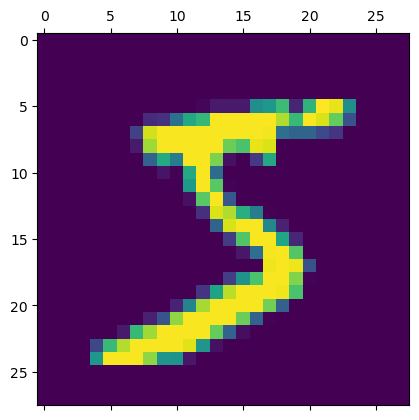

In [9]:
plt.matshow(X_train[0])

In [10]:
y_train[0]

5

In [11]:
X_train = X_train / 255
X_test = X_test / 255

In [12]:
X_train_flattened = X_train.reshape(len(X_train), 28*28)
X_test_flattened = X_test.reshape(len(X_test), 28*28)

In [13]:
X_train_flattened.shape

(60000, 784)

<h3 style='color:purple'>Using Flatten layer so that we don't have to call .reshape on input dataset</h3>

In [34]:
model = keras.Sequential([
    keras.layers.Flatten(input_shape=(28, 28)),
    keras.layers.Dense(100, activation='relu'),
    keras.layers.Dense(10, activation='sigmoid')
])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.fit(X_train, y_train, epochs=5)

/opt/conda/lib/python3.10/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.8684 - loss: 0.4550
Epoch 2/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9607 - loss: 0.1331
Epoch 3/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9720 - loss: 0.0940
Epoch 4/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9804 - loss: 0.0669
Epoch 5/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9853 - loss: 0.0512


In [35]:
model.evaluate(X_test,y_test)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9696 - loss: 0.0963


[0.08255854994058609, 0.9739999771118164]

In [18]:
# model.save("saved_model")

# Save the model in the Keras H5 format
model.save("./model.h5")

<h3 style='color:blue'>(1) Post training quantization</h3>

**Without quantization**

In [19]:
# converter = tf.lite.TFLiteConverter.from_saved_model("./saved_model")
# tflite_model = converter.convert()

# Load the Keras model
model = keras.models.load_model("./model.h5")

# Convert the model to TFLite
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the converted model to a file
with open("model.tflite", "wb") as f:
    f.write(tflite_model)

INFO:tensorflow:Assets written to: /tmp/tmpkx0w5xcq/assets


INFO:tensorflow:Assets written to: /tmp/tmpkx0w5xcq/assets


Saved artifact at '/tmp/tmpkx0w5xcq'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 28, 28), dtype=tf.float32, name='input_layer')
Output Type:
  TensorSpec(shape=(None, 10), dtype=tf.float32, name=None)
Captures:
  126105143535648: TensorSpec(shape=(), dtype=tf.resource, name=None)
  126105143539520: TensorSpec(shape=(), dtype=tf.resource, name=None)
  126105143628496: TensorSpec(shape=(), dtype=tf.resource, name=None)
  126105143632368: TensorSpec(shape=(), dtype=tf.resource, name=None)


W0000 00:00:1722967663.887922      98 tf_tfl_flatbuffer_helpers.cc:392] Ignored output_format.
W0000 00:00:1722967663.887985      98 tf_tfl_flatbuffer_helpers.cc:395] Ignored drop_control_dependency.
2024-08-06 18:07:43.889028: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmpkx0w5xcq
2024-08-06 18:07:43.889654: I tensorflow/cc/saved_model/reader.cc:52] Reading meta graph with tags { serve }
2024-08-06 18:07:43.889680: I tensorflow/cc/saved_model/reader.cc:147] Reading SavedModel debug info (if present) from: /tmp/tmpkx0w5xcq
2024-08-06 18:07:43.898459: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:388] MLIR V1 optimization pass is not enabled
2024-08-06 18:07:43.899324: I tensorflow/cc/saved_model/loader.cc:236] Restoring SavedModel bundle.
2024-08-06 18:07:43.926341: I tensorflow/cc/saved_model/loader.cc:220] Running initialization op on SavedModel bundle at path: /tmp/tmpkx0w5xcq
2024-08-06 18:07:43.935299: I tensorflow/cc/saved_model/loader.cc

**With quantization**

In [20]:
# converter = tf.lite.TFLiteConverter.from_saved_model("./saved_model")
# converter.optimizations = [tf.lite.Optimize.DEFAULT]
# tflite_quant_model = converter.convert()

# Load the Keras model
model = keras.models.load_model("./model.h5")

# Convert the model to TFLite with optimization
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]

# Convert the model
tflite_quant_model = converter.convert()

# Save the converted model to a file
with open("model_quant.tflite", "wb") as f:
    f.write(tflite_quant_model)


INFO:tensorflow:Assets written to: /tmp/tmp61xsj33d/assets


INFO:tensorflow:Assets written to: /tmp/tmp61xsj33d/assets


Saved artifact at '/tmp/tmp61xsj33d'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 28, 28), dtype=tf.float32, name='input_layer')
Output Type:
  TensorSpec(shape=(None, 10), dtype=tf.float32, name=None)
Captures:
  126105143633072: TensorSpec(shape=(), dtype=tf.resource, name=None)
  126105143630960: TensorSpec(shape=(), dtype=tf.resource, name=None)
  126105143531776: TensorSpec(shape=(), dtype=tf.resource, name=None)
  126105143532656: TensorSpec(shape=(), dtype=tf.resource, name=None)


W0000 00:00:1722967666.885748      98 tf_tfl_flatbuffer_helpers.cc:392] Ignored output_format.
W0000 00:00:1722967666.885797      98 tf_tfl_flatbuffer_helpers.cc:395] Ignored drop_control_dependency.
2024-08-06 18:07:46.886135: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmp61xsj33d
2024-08-06 18:07:46.886821: I tensorflow/cc/saved_model/reader.cc:52] Reading meta graph with tags { serve }
2024-08-06 18:07:46.886846: I tensorflow/cc/saved_model/reader.cc:147] Reading SavedModel debug info (if present) from: /tmp/tmp61xsj33d
2024-08-06 18:07:46.891690: I tensorflow/cc/saved_model/loader.cc:236] Restoring SavedModel bundle.
2024-08-06 18:07:46.919189: I tensorflow/cc/saved_model/loader.cc:220] Running initialization op on SavedModel bundle at path: /tmp/tmp61xsj33d
2024-08-06 18:07:46.928168: I tensorflow/cc/saved_model/loader.cc:462] SavedModel load for tags { serve }; Status: success: OK. Took 42041 microseconds.


Read this article for post training quantization: https://www.tensorflow.org/model_optimization/guide/quantization/post_training

In [21]:
len(tflite_model)

319948

In [23]:
len(tflite_quant_model)

86008

You can see above that quantizated model is 1/4th the size of a non quantized model

In [39]:
# pip install tensorflow_model_optimization
!pip install tensorflow tensorflow-model-optimization


In [29]:
# with open("tflite_model.tflite", "wb") as f:
#     f.write(tflite_model)

In [30]:
# with open("tflite_quant_model.tflite", "wb") as f:
#     f.write(tflite_quant_model)

Once you have above files saved to a disk, check their sizes. Quantized model will be obvi

pip install --upgrade tensorflow tensorflow-model-optimization
<h3 style='color:blue'>(2) Quantization aware training</h3>

In [46]:
import tensorflow as tf
import tensorflow_model_optimization as tfmot

print(tf.__version__)
print(tfmot.__version__)


# Step 2: Apply quantization aware training
quantize_model = tfmot.quantization.keras.quantize_model
q_aware_model = quantize_model(model)

q_aware_model.compile(optimizer='adam',
                      loss='sparse_categorical_crossentropy',
                      metrics=['accuracy'])

q_aware_model.summary()

ModuleNotFoundError: No module named 'tf_keras'

In [22]:
q_aware_model.fit(X_train, y_train, epochs=1)

1875/1875 [==============================] - 7s 4ms/step - loss: 0.0438 - accuracy: 0.9866


In [23]:
q_aware_model.evaluate(X_test, y_test)

313/313 [==============================] - 1s 2ms/step - loss: 0.0802 - accuracy: 0.9755


[0.08016839623451233, 0.9754999876022339]

In [24]:
converter = tf.lite.TFLiteConverter.from_keras_model(q_aware_model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]

tflite_qaware_model = converter.convert()

INFO:tensorflow:Assets written to: C:\Users\dhava\AppData\Local\Temp\tmpqnsx4bvx\assets


INFO:tensorflow:Assets written to: C:\Users\dhava\AppData\Local\Temp\tmpqnsx4bvx\assets


In [25]:
len(tflite_qaware_model)

82376

In [26]:
with open("tflite_qaware_model.tflite", 'wb') as f:
    f.write(tflite_qaware_model)

In [ ]:
import tensorflow as tf
from tensorflow import keras
import tensorflow_model_optimization as tfmot
import numpy as np

# Load MNIST dataset
(X_train, y_train), (X_test, y_test) = keras.datasets.mnist.load_data()

# Normalize the input data
X_train, X_test = X_train / 255.0, X_test / 255.0

# Create the original model
model = keras.Sequential([
    keras.layers.Flatten(input_shape=(28, 28)),
    keras.layers.Dense(100, activation='relu'),
    keras.layers.Dense(10, activation='softmax')  # Change to softmax for classification
])

# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
model.fit(X_train, y_train, epochs=1)

# Apply quantization aware training
quantize_model = tfmot.quantization.keras.quantize_model
try:
    q_aware_model = quantize_model(model)
except ValueError as e:
    print("Error during quantization:", e)
    print("Model type:", type(model))
    # Instead of exiting, handle the error, maybe try a different quantization approach
    q_aware_model = None  # Assign a value to avoid the NameError later

# Proceed only if quantization was successful
if q_aware_model:
    # Recompile the quantized model
    q_aware_model.compile(optimizer='adam',
                          loss='sparse_categorical_crossentropy',  # Use the same loss as before
                          metrics=['accuracy'])

    # Summarize the quantized model
    q_aware_model.summary()

    # Continue training with the quantization aware model
    q_aware_model.fit(X_train, y_train, epochs=5)

    # Convert the quantized model to TFLite format
    converter = tf.lite.TFLiteConverter.from_keras_model(q_aware_model)
    converter.optimizations = [tf.lite.Optimize.DEFAULT]

    tflite_quant_model = converter.convert()

    # Save the converted model to a file
    with open("q_aware_model.tflite", "wb") as f:
        f.write(tflite_quant_model)

    print("Quantized model saved as q_aware_model.tflite")
else:
    print("Quantization failed, skipping further steps.")